<h1>Example: Gibbs Sampling</h1>
<hr>
DISTRIBUTION STATEMENT A. Approved for public release. Distribution is unlimited.

This material is based upon work supported by the Under Secretary of Defense for
Research and Engineering under Air Force Contract No. FA8702-15-D-0001. Any opinions,
findings, conclusions or recommendations expressed in this material are those of the
author(s) and do not necessarily reflect the views of the Under Secretary of Defense
for Research and Engineering.

© 2023 Massachusetts Institute of Technology.

The software/firmware is provided to you on an As-Is basis

Delivered to the U.S. Government with Unlimited Rights, as defined in DFARS Part
252.227-7013 or 7014 (Feb 2014). Notwithstanding any copyright notice, U.S. Government
rights in this work are defined by DFARS 252.227-7013 or DFARS 252.227-7014 as detailed
above. Use of this work other than as specifically authorized by the U.S. Government
may violate any copyrights that exist in this work.

In [1]:
import numpy             as np
import numpy.linalg      as la
import scipy.linalg      as sla
import pyLIQTR.sim_methods.quantum_ops  as  qops 
from   pyLIQTR.sim_methods.simqsp import SimQSP
import matplotlib.pyplot  as plt
from itertools import combinations
import mpmath                            as mpm
from pyLIQTR.sim_methods.fitter                import Fitter
from pyLIQTR.sim_methods.angler                import Angler
import shadows as sh

<hr>
<h2><u> Quantum Gibbs States </u></h2>
<h3>Background</h3>

This notebook describes how `pyLIQTR` can be used to sample from Gibbs states using QSP (simulated at an operator level). For a full background on Gibbs states, see Tutorial 1a. 

Let us begin by considering an example of a 3-qubit system subject to an XXZ-Heisenberg Hamiltonian. The details behind implementing such a Hamiltonian with `pyLIQTR` can be found in the 'Heisenberg' tutorial. Here, we calculate the Gibbs state for this example.

In [2]:
# Define Hamiltonian as in Heisenberg tutorials, using the XXZ model

# Hamiltonian parameters

N    =    3;       

J_z  =    1.0;

J_x  =    1.1*J_z;     J_y  =   J_x;               
h_x  =   -1.0*J_z;     h_y  =   0.0*J_z;     h_z  =   0.0*J_z;

In [3]:
# Generate input parameter sets
tuples,types,coeffs = qops.params_heisenberg_1d(N,
                                                J_x=J_x,J_y=J_y,J_z=J_z,
                                                h_x=h_x,h_y=h_y,h_z=h_z,
                                                periodic=False)

# Generate Hamiltonian Matrix
H = qops.ham_from_pauli_tuples(tuples,types,coeffs,N)

# Let us define our inverse temperature as beta = 0.5
beta = 1.5

In [4]:
# Calculate Gibbs State
rho_beta = sla.expm(-beta*H)
Z = np.trace(rho_beta)
rho_beta = rho_beta/Z

<h3>Gibbs Sampling</h3>

In these tutorials, we implement an algorithm described in Coopmans et al which rather than explicitly preparing Gibbs states, seeks to sample them by estimating their expectation values for some sets of operators. For this example, our operator set will consist of all one and two qubit Pauli operators, but in principle any set of Hermitian operators will do.

The following generates this operator set $O$, and calculates the 'true' expectation values of each operator for the Gibbs state calculated above.

In [5]:
# Define our set of operators as all one and two qubit Pauli operators (they need only be Hermitian)
op_tuples = list(combinations(range(N), 2))

paulis = [qops.px,qops.py,qops.pz]
O_list = []
O = []

# One qubit pauli operators over N qubits
for i in range(N):
    ops = [qops.id]*N

    op_ids = [3]*N

    for j in range(3):
        ops[i] = paulis[j]
        O.append(qops.multikron(ops))

        op_ids[i] = j
        O_list.append(op_ids.copy())

# Two qubit pauli operators over N qubits
for tuple in op_tuples:
    ops = [qops.id]*N
    op_ids = [3]*N
    for i in range(3):
        for j in range(3):
            ops[tuple[0]] = paulis[i]
            ops[tuple[1]] = paulis[j]
            O.append(qops.multikron(ops))

            op_ids[tuple[0]] = i
            op_ids[tuple[1]] = j
            O_list.append(op_ids.copy())

In [6]:
# Expectation values of operators for Gibbs State
Gbs_expct = sh.expect_set(O, rho_beta)

Specifically, this algorithm estimates the expectation values using the Classical Shadows. Classical shadow tomography is used to efficiently predict properties of a quantum state through classical representations constructed from randomized measurements.

We start by calculating the number of shadows necessary for estimations of given error thresholds, then perform the estimations on the exact Gibbs state. See Tutorial 1a for details on this process.

In [7]:
delta = 0.01
epsilon = np.array([1 - 0.1*x for x in range(9)])


vars = []
for o_j in O:
    vars.append(3**2 - abs(np.trace(rho_beta@o_j)**2))

K = int(np.rint((9/2)*np.log(len(O)/delta)))
S = np.rint((2/(epsilon**2))*max(vars)).astype(int) + np.array([1]*len(epsilon)) # Fulfill strictly greater than requirement

sizes = list(K*S)
print('number of shadows required for each error tolerance, epsilon:')
print(sizes)


number of shadows required for each error tolerance, epsilon:
[703, 851, 1073, 1406, 1887, 2701, 4218, 7437, 16687]


703
851
1073
1406
1887
2701
4218
7437
16687


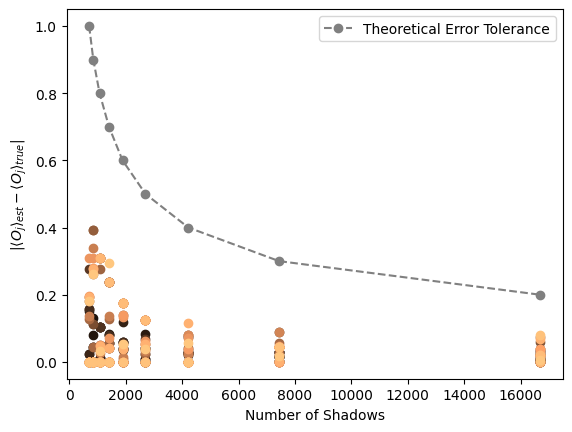

In [8]:
# Classical Shadows for exact  state
gibshadow_errors = []

# Calculate n_s-sized sets of shadows, their expectation values, and errors
for n_s in sizes:
    estimates = []

    print(n_s)
    for i in range(n_s):
        estimates.append(sh.shadow_estimation(rho_beta, N, O_list))

    shadow_expct = sh.med_of_mean(np.array(estimates), K)
    error = abs(np.subtract(Gbs_expct, shadow_expct))
    gibshadow_errors.append(error)


plt.xlabel('Number of Shadows')
plt.ylabel(r'|$\langle O_j \rangle _{est} - \langle O_j \rangle _{true}$|')
i = 0
for errors in np.array(gibshadow_errors).T:
    i += 1
    plt.scatter(sizes, errors, color=plt.cm.copper(i/len(O)))
plt.plot(sizes,epsilon, '--o', color='grey', label='Theoretical Error Tolerance')
plt.legend()
plt.show()

<h3>Thermal Pure Quantum States </h3>

A Thermal Pure Quantum (TPQ) state is a pure state which represents an equilibrium state; in other words, a TPQ state $\ket{psi_\beta}$ can estimate expectation values for a thermal mixed state, like our Gibbs state. Thus, Coopmans et al argue that the classical shadows of the Gibbs state and the appropriately constructed TPQ states should be roughly the same, and we can estimate our expectation values with the latter. Moreover, they show that such TPQ states can be generated through imaginary time evolution like so:

\begin{equation}
\ket{\psi_\beta} = \frac{e^{-\beta H/2}U\ket{0}}{\sqrt{\braket{0|U^{\dagger}e^{-\beta H}U|0}}}
\end{equation}

Where $U$ is another random clifford unitary, and the exponential represents the imaginary time evolution under our Hamiltonian. In the last tutorial, we constructed classical shaodws using this explicit formula for TPQ states:

In [9]:
# Build initial state for TPQ Prep
psi0 = qops.multikron([qops.sz_u]*N)             # Generate the wavefunction as a 
psi0 = psi0 / la.norm(psi0)                      # Kronecker product and normalize it.

703
851
1073
1406
1887
2701
4218
7437
16687


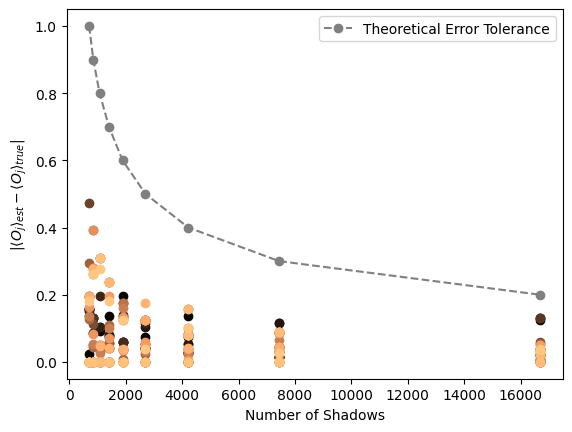

In [10]:
# Classical Shadows for Explicitly calculated TPQ states
tpq_errors = []

# Calculate n_s-sized sets of shadows, their expectation values, and errors
for n_s in sizes:
    estimates = []

    print(n_s)
    for i in range(n_s):
        # Calculate "exact" TPQ 
        U = sh.random_unitary(N, 0.1)
        phi = np.matmul(U, psi0) 
        psiB = np.matmul(sla.expm(-beta*H/2), phi) # imaginary time evolution
        psiB = psiB/la.norm(psiB) # normalize

        estimates.append(sh.shadow_estimation(np.outer(psiB, psiB.conj()), N, O_list))

    shadow_expct = sh.med_of_mean(np.array(estimates), K)
    error = abs(np.subtract(Gbs_expct, shadow_expct))
    tpq_errors.append(error)

plt.xlabel('Number of Shadows')
plt.ylabel(r'|$\langle O_j \rangle _{est} - \langle O_j \rangle _{true}$|')
i = 0
for errors in np.array(tpq_errors).T:
    i += 1
    plt.scatter(sizes, errors, color=plt.cm.copper(i/len(O)))
plt.plot(sizes,epsilon, '--o', color='grey', label='Theoretical Error Tolerance')
plt.legend()
plt.show()

However, to prepare TPQ states on a quantum circuit, we can only utilize unitary operators, which $e^{-\beta H/2}$ is not. We require a way to approximate this with unitary operators, which is were Quantum Signal Processing enters the picture.

Here, we implement an operator-level simulation of QSP to verify the accuracy of a given phase angle sequence. However, in order to block encode our Hamiltonian we must rescale it such that its spectrum falls within $[0,1]$. We achieve this through Min-Max rescaling: $\tilde{H} = (H - \lambda_{min}I)/(\lambda_{max}-\lambda_{min})$ with imaginary time: $\tau = \beta(\lambda_{max}-\lambda_{min})/2$. Thus, evolving our random pure state with $\tilde{H}$ for time $\tau$ approximates:
\begin{equation}
e^{-\tau \tilde{H}} = e^{-\beta \lambda_{min}/2} e^{-\beta H/2}
\end{equation}
which agrees with our desired non-unitary operator $e^{-\beta H/2}$ up to a constant factor, which cancels out with normalization when constructing $\ket{\psi _\beta}$.

In [11]:
# Pre processing for QSP requires Min-Max Rescaling

evals,evecs = la.eig(H)

print("Max Eigenvalue: ", np.max(evals))
print("Min Eigenvalue: ", np.min(evals))


e_min = np.min(evals)
e_max = np.max(evals)

ID_n = np.eye(2**N)

H_rs = (H - e_min*ID_n) / (e_max - e_min)        # min/max rescaling  

tau = beta*(e_max-e_min).real/2.0

Max Eigenvalue:  (5.203880206381988+0j)
Min Eigenvalue:  (-5.26764116321077+0j)


Next, we generate phase angles which encode the imaginary time evolution with QSP. We generate a $d$-degree polynomial fit to our exponential function using the `Fitter` module of ``pyLIQTR``. The polynomial is then passed to the `Angler` module which generates our phase angles. For the case of $\beta = 1.5$,  we find that a 24-degree polynomial is sufficient to keep estimation errors within the theoretical error bound prescribed to the classical shadows.

In [12]:
deg   = 24 

exp_ite  =  lambda x : mpm.exp(-tau*np.abs(x))

hyp_ite = lambda x : mpm.cosh(tau*np.abs(x)) - mpm.sinh(tau*np.abs(x))

In [13]:
Fit  = Fitter(exp_ite, deg, parity=0, kappa = 8.0)

Fit.remez()

Fit.root_solver = 'ridder'  # switch to a slightly faster root solver
                            # though convergence can be erratic.
Fit.r_eps_tot   = 1.0e-6

    
# Angle generation
Ang = Angler(cheb_poly=Fit, bfgs_conv=1e-8, max_iter=400 );   
Ang.gradient_optimization();

################################################################################
#    FITTER:REMEZ   ---   Approximation in a Chebyshev polynomial basis.       #
################################################################################ 

REMEZ		 Iter:  0 	  Linf_Err:   0.0008543487564783894
REMEZ		 Iter:  1 	  Linf_Err:   0.0003093112306275133
REMEZ		 Iter:  2 	  Linf_Err:   0.00016515468684929007
REMEZ		 Iter:  3 	  Linf_Err:   7.548958005893816e-05
REMEZ		 Iter:  4 	  Linf_Err:   6.735943151446797e-05
REMEZ		 Iter:  5 	  Linf_Err:   6.698028073241294e-05

REMEZ:		FITTING COMPLETE!

################################################################################
#             GRADIENT OPTIMIZER for QSP Phase Angle Determination             #
################################################################################ 


Iteration		Max. Obj.

1 			1.270033e-03
2 			2.609843e-04
3 			9.659893e-06
4 			3.253408e-07
5 			1.661612e-08
6 			1.415047e-10
7 			8.996119e-13
8 			5.4

Operator-level simulations are performed using the `SimQSP` class.  The QSP phase angles are passed when constructing the object, and the standard (minimal) block encoding is prepared by calling the member function `get_qsp_operators`:

In [14]:
# Create simulation object and encode the Hamiltonian
Sim_q = SimQSP(angler=Ang)

Sim_q.get_qsp_operators(H_rs)

We set the signal state for our $R$-convention QSP encoding and generate our time evolution operator $\mathcal{U}_{QSP}(\tau)$

In [15]:
# Prepare signal state and calculate unitary operator
sig_qsp  = np.kron(np.array([[1,1]]),np.eye(2**N)) / np.sqrt(2)
U_qsp = sig_qsp @ Sim_q.qsp_sequence() @ sig_qsp.T

Finally, we use $\mathcal{U}_{QSP}(\tau)$ in our operator sequence to approximately prepare a TPQ state which we then use to calulcate classical shadows and their error in estimating expectation values. The following plots these errors along with the previously calculated ones for the Gibbs state and exact TPQ.

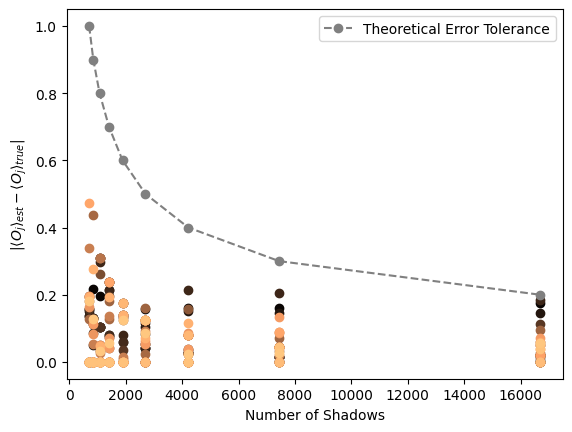

In [16]:
# Classical Shadows for TPQ States prepared by QSP
qsp_errors = []

# Calculate n_s-sized sets of shadows, their expectation values, and errors
for n_s in sizes:
    estimates = []

    for i in range(n_s):

        # Prepare approximate TPQ 
        U = sh.random_unitary(N, 0.1)
        phi = np.matmul(U, psi0)

        psiB_ap = np.matmul(U_qsp, phi) # Imaginary time evolution via QSP 
        psiB_ap = psiB_ap / la.norm(psiB_ap)

        estimates.append(sh.shadow_estimation(np.outer(psiB_ap, psiB_ap.conj()), N, O_list))

    shadow_expct = sh.med_of_mean(np.array(estimates), K)
    error = abs(np.subtract(Gbs_expct, shadow_expct))
    qsp_errors.append(error)

plt.xlabel('Number of Shadows')
plt.ylabel(r'|$\langle O_j \rangle _{est} - \langle O_j \rangle _{true}$|')
i = 0
for errors in np.array(qsp_errors).T:
    i += 1
    plt.scatter(sizes, errors, color=plt.cm.copper(i/len(O)))
plt.plot(sizes,epsilon, '--o', color='grey', label='Theoretical Error Tolerance')
plt.legend()
plt.show()

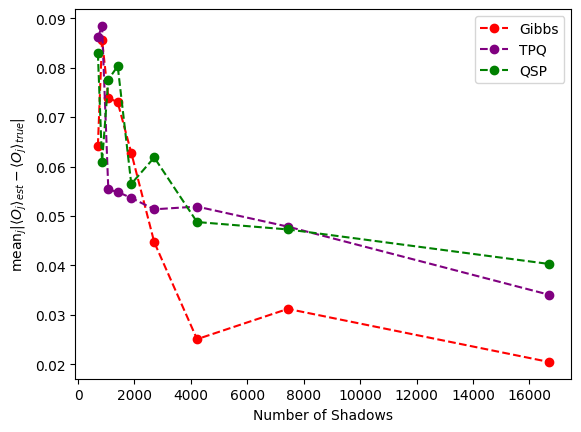

In [17]:
plt.xlabel('Number of Shadows')
plt.ylabel(r'mean$_j | \langle O_j \rangle _{est} - \langle O_j \rangle _{true}$|')
plt.plot(sizes, np.mean(gibshadow_errors, axis=1), '--o', color='red', label = 'Gibbs')
plt.plot(sizes,np.mean(tpq_errors, axis=1), '--o', color='purple', label = 'TPQ')
plt.plot(sizes,np.mean(qsp_errors, axis=1), '--o', color='green', label = 'QSP')
plt.legend()
plt.show()

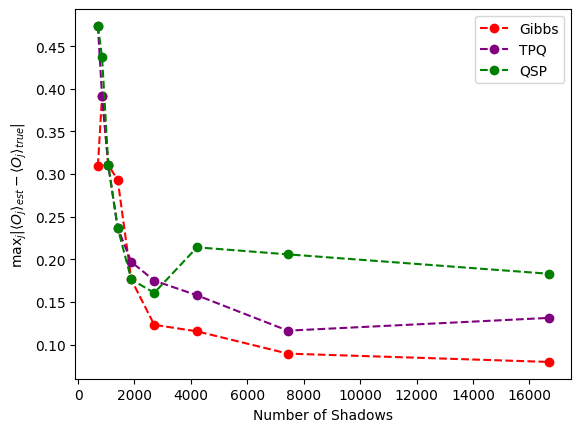

In [18]:
plt.xlabel('Number of Shadows')
plt.ylabel(r'max$_j | \langle O_j \rangle _{est} - \langle O_j \rangle _{true}$|')
plt.plot(sizes, np.max(gibshadow_errors, axis=1), '--o', color='red', label = 'Gibbs')
plt.plot(sizes,np.max(tpq_errors, axis=1), '--o', color='purple', label = 'TPQ')
plt.plot(sizes,np.max(qsp_errors, axis=1), '--o', color='green', label = 'QSP')
plt.legend()
plt.show()

[1] L. Coopmans, Y. Kikuchi, and M. Benedetti, “Predicting Gibbs-State Expectation Values with Pure Thermal Shadows,” PRX Quantum, vol. 4, no. 1, Jan. 2023, doi: 10.1103/prxquantum.4.010305. 

[2] H.-Y. Huang, R. Kueng, and J. Preskill, “Predicting many properties of a quantum system from very few measurements,” Nature Physics, vol. 16, no. 10, pp. 1050–1057, Jun. 2020, doi: 10.1038/s41567-020-0932-7.

[3] C. Dankert, R. Cleve, J. Emerson, and E. Livine, “Exact and approximate unitary 2-designs and their application to fidelity estimation,” Physical Review A, vol. 80, no. 1, Jul. 2009, doi: 10.1103/physreva.80.012304. 

[4] B. Doolittle and R. Wiersema, Classical shadows — pennylane.ai. https://pennylane.ai/qml/demos/tutorial_classical_shadows, 2021. [Online]. Available: https://pennylane.ai/qml/demos/tutorial_classical_shadows